In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pywt

from itertools import islice
from collections import deque

from tensorflow.python.keras.layers import Input, Dense,RNN,LSTMCell
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.losses import mean_absolute_percentage_error,mae

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import statespace

from pandas.plotting import autocorrelation_plot

from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mae(A,F):
    return np.mean(np.abs(A -F))

def get_family(wave):
  if 'bior' in wave:
    return 'bior'
  elif 'coif' in wave:
    return 'coif'
  elif 'db' in wave:
    return 'db'
  elif 'dmey' in wave:
    return 'dmey'
  elif 'rbio' in wave:
    return 'rbio'
  elif 'sym' in wave:
    return 'sym'
  else:
    return 'haar'

def denoise(original,WAVELET):

  signal = original.values

  coeffs = pywt.wavedec(signal, WAVELET)
  coeffs[1:] = (pywt.threshold(detail,
                              value=0.5 * np.std(detail), 
                              mode="soft" ) for detail in coeffs[1:])
  reconstructed_signal = pywt.waverec(coeffs, WAVELET)
  return pd.Series(reconstructed_signal[:-1],index=original.index)


# Wavelet Analysis

In [3]:
runAnalysis = False

all_discrete_wavelets = pywt.wavelist(kind='discrete')


def get_arima_aic(a_train):
  modA = sm.tsa.statespace.SARIMAX(a_train,freq='5T', order=(3,1,6),exog = exog_train )                       
  res = modA.fit()
  return res.aic

if runAnalysis:
  all_aic = []
  for wave in all_discrete_wavelets:
    
    signal = denoise(wave)
    signal.index = original.index
    wave_aic = get_arima_aic(signal[:train_size])
    all_aic.append(wave_aic)
    #print('Denoising with ',wave, 'reported AIC of ',wave_aic)

  waveTest = pd.DataFrame(all_aic,index=all_discrete_wavelets,columns=['aic'])
  waveTest = waveTest.reset_index()
  waveTest = waveTest.rename(columns={'index':'wavelet'})

  waveTest.to_csv('waveletAIC.csv',index=False)

  waveTest['family'] = waveTest.wavelet.apply(get_family)

  aicOrig = get_arima_aic(original[:train_size])

  waveTest['diff'] = aicOrig - waveTest['aic']
  waveDiff = waveTest.groupby('family').agg({'diff':'mean'}).sort_values(by='diff')

  waveColors = ['red' if x < 0 else 'green' for x in waveDiff['diff']]

  fig,ax = plt.subplots()
  plt.vlines(x=waveDiff.index, ymin=0, ymax=waveDiff['diff'], 
                  color=waveColors, alpha=0.5, linewidth=8)
  ax.set_xlabel('Wavelet family')
  ax.set_ylabel('Difference in AIC over original series')
  plt.axhline()
  plt.grid(linestyle='--', alpha=0.7,axis='y')

  plt.show()


# Load Data

In [4]:
df = pd.read_csv('winProxy.csv',parse_dates=True,index_col=0)
original = df.CPU
df['smooth_CPU'] = denoise(original,'db38')

df.diskwrite = df.diskwrite.shift(periods=1)
df.diskwrite = df.diskwrite.fillna(0)

# Random Walk

In [5]:
#test_set = (original.index > np.datetime64('2020-07-12T19:30:00')) & (original.index < np.datetime64('2020-07-12T22:10:00'))
#rw_set = (original.index > np.datetime64('2020-07-12T19:25:00')) & (original.index < np.datetime64('2020-07-12T22:05:00'))
test_start_date = '2020-07-12T12:30:00'
test_end_date = '2020-07-12T15:00:00'

rw_start_date = '2020-07-12T12:25:00'
rw_end_date = '2020-07-12T14:55:00'

test_set = (original.index > np.datetime64(test_start_date)) & (original.index < np.datetime64(test_end_date))
rw_set = (original.index > np.datetime64(rw_start_date)) & (original.index < np.datetime64(rw_end_date))

test_index = original.index[test_set]

Y_test = original[test_set].values
rw_forecast = original[rw_set].values
#original[test_set].plot()

In [6]:
print("MAPE : ",mape(Y_test+1,rw_forecast+1))
print("SMAPE : ",smape(Y_test+1,rw_forecast+1))
print("MAE : ",mae(Y_test+1,rw_forecast+1))

MAPE :  26.693603709397117
SMAPE :  24.0221643905739
MAE :  1.4689655172413794


## In Sample forecast

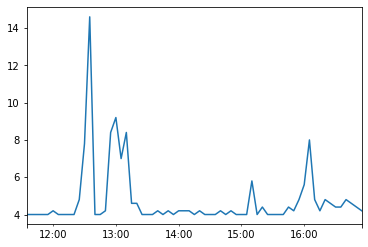

In [7]:
#test_set = (original.index > np.datetime64('2020-07-12T19:30:00')) & (original.index < np.datetime64('2020-07-12T22:10:00'))
#rw_set = (original.index > np.datetime64('2020-07-12T19:25:00')) & (original.index < np.datetime64('2020-07-12T22:05:00'))
in_start_date = '2020-06-19T11:30:00'
in_end_date = '2020-06-19T17:00:00'

rw_in_start_date = '2020-06-19T11:25:00'
rw_in_end_date = '2020-06-19T16:55:00'

in_set = (original.index > np.datetime64(in_start_date)) & (original.index < np.datetime64(in_end_date))
rw_in_set = (original.index > np.datetime64(rw_in_start_date)) & (original.index < np.datetime64(rw_in_end_date))

test_in_index = original.index[in_set]

Y_in_test = original[in_set].values
rw_in_forecast = original[rw_in_set].values
original[in_set].plot()


In [8]:
print("MAPE : ",mape(Y_in_test+1,rw_in_forecast+1))
print("SMAPE : ",smape(Y_in_test+1,rw_in_forecast+1))
print("MAE : ",mae(Y_in_test+1,rw_in_forecast+1))

MAPE :  12.025087252369033
SMAPE :  10.430399751821371
MAE :  0.8


# ARIMA



In [9]:
train_size = round(len(df) * 0.8)
arima_train = df.smooth_CPU[:train_size] #df.CPU[:train_size]
exog_train = df.diskwrite[:train_size]

arima_test = df.smooth_CPU[train_size:]
exog_test = df.diskwrite[train_size:]




test_set = (df.CPU.index > np.datetime64(test_start_date)) & (df.CPU.index < np.datetime64(test_end_date))


In [10]:
mod = sm.tsa.statespace.SARIMAX(arima_train,freq='5T', order=(3,1,6),exog = exog_train )                       
res = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
y_hat = res.predict(start = arima_test.index[0], end=arima_test.index[-1],exog = pd.DataFrame(exog_test))
arima_forecast = y_hat[(y_hat.index > test_start_date) & (y_hat.index < test_end_date)]

print("MAPE : ",mape(Y_test+1,arima_forecast+1))
print("SMAPE : ",smape(Y_test+1,arima_forecast+1))
print("MAE : ",mae(Y_test+1,arima_forecast+1))

MAPE :  16.143722947701892
SMAPE :  19.102336406987085
MAE :  1.1059634563306446


## In sample prediction

In [12]:
in_set = (df.CPU.index > np.datetime64(in_start_date)) & (df.CPU.index < np.datetime64(in_end_date))

y_hat = res.predict(start = arima_train.index[0], end=arima_train.index[-1],exog = pd.DataFrame(exog_train))
arima_in_forecast = y_hat[(y_hat.index > in_start_date) & (y_hat.index < in_end_date)]

print("MAPE : ",mape(Y_in_test+1,arima_in_forecast+1))
print("SMAPE : ",smape(Y_in_test+1,arima_in_forecast+1))
print("MAE : ",mae(Y_in_test+1,arima_in_forecast+1))

MAPE :  12.271696543826781
SMAPE :  13.442744390057086
MAE :  0.8842940922004959


## ARIMA Grid Search

In [13]:
if runAnalysis:
  row = []
  for p in range(7):
    for q in range(7):
      grid_order = (p,1,q)
      mod = sm.tsa.statespace.SARIMAX(arima_train,freq='5T', order=grid_order,exog = exog_train )                       
      res = mod.fit()
      print("For ARIMA ",grid_order,"AIC",res.aic)
      row.append([p,q,res.aic]) 


In [14]:
if runAnalysis:
  arima_search = pd.DataFrame(row,columns= ['p','q','AIC'])
  arima_search.head()

In [15]:
if runAnalysis:
  arima_search.to_csv('grid_search_arima.csv')

In [16]:
if runAnalysis:
  arima_search = pd.read_csv('grid_search_arima.csv')
  minV = arima_search.AIC.min()
  maxV = arima_search.AIC.max()
  arima_search = pd.DataFrame(np.reshape(arima_search.AIC.to_numpy(),(-1,7)))

  plotMe = arima_search - minV
  plotMe[plotMe > 100] = 100

  ax = sns.heatmap(plotMe,cmap="YlGnBu")
  ax.set_xlabel('AR component (p)')
  ax.set_ylabel('MA component (q)')

  plt.show()

# ANN

In [17]:
def sliding_window_iter(iterable, size):
    """..."""
    iterable = iter(iterable)
    window = deque(islice(iterable, size), maxlen=size)
    for item in iterable:
        yield np.array(window)
    window.append(item)
    if window:
    # needed because if iterable was already empty before the `for`,
    # then the window would be yielded twice.
        yield np.array(window)

In [18]:
time_window = 4
input_dims = 8
X = []
for row in sliding_window_iter(df.smooth_CPU.values,time_window):
    X.append(row)

X = pd.DataFrame(X[:-1])
Y = df.smooth_CPU.iloc[time_window:]


X['hour'] = df.index.hour[time_window:]
X['weekday'] = df.index.weekday[time_window:]
X['IOBalance'] = df.IOBalance.to_numpy()[time_window:]
X['diskwrite'] = df.diskwrite.to_numpy()[time_window:]

In [19]:
X_train = X.iloc[:train_size,:]
Y_train = Y[:train_size]

In [20]:
np.random.seed(42)
activation_fn = 'relu'

model = Sequential()
model.add(Dense(8, input_dim=input_dims,  activation=activation_fn))
model.add(Dense(4, activation=activation_fn))
model.add(Dense(1, ))

model.compile(loss='mae',
                optimizer='adam',
                metrics = ['mse','mae','mape']
              )

In [21]:
history = model.fit(X_train, Y_train,
                    epochs=100, batch_size=32,
                    validation_split=0.2,shuffle=False,verbose=0)

In [22]:
X_test = X[test_set[4:]]
ann_forecast = model.predict(X_test).flatten()
print("MAPE : ",mape(Y_test+1,ann_forecast+1))
print("SMAPE : ",smape(Y_test+1,ann_forecast+1))
print("MAE : ",mae(Y_test+1,ann_forecast+1))

MAPE :  15.5373965237773
SMAPE :  18.515695557640715
MAE :  1.068843256194016


## In sample prediction


In [23]:
X_in_test = X[in_set[4:]]
ann_in_forecast = model.predict(X_in_test).flatten()
print("MAPE : ",mape(Y_in_test+1,ann_in_forecast+1))
print("SMAPE : ",smape(Y_in_test+1,ann_in_forecast+1))
print("MAE : ",mae(Y_in_test+1,ann_in_forecast+1))

MAPE :  16.38368949134301
SMAPE :  19.527789800683106
MAE :  1.163958828999446


# Results



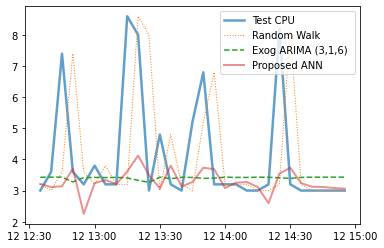

In [24]:
#labs = ['12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
fig,ax = plt.subplots()
#ax.set_xticklabels(labs)
#ax.set_ylim(0,15)
_ = ax.plot(pd.Series(Y_test,index = test_index),linewidth=2.5,label='Test CPU',alpha=0.7)
_ = ax.plot(pd.Series(rw_forecast,index = test_index),linewidth=1,linestyle='dotted',label = 'Random Walk')
_ = ax.plot(pd.Series(arima_forecast ,index = test_index),linewidth=1.5,linestyle='dashed',label = 'Exog ARIMA (3,1,6) ')
_ = ax.plot(pd.Series(ann_forecast ,index = test_index),linewidth=2,alpha=0.5, label = 'Proposed ANN')

plt.legend(loc='upper right')

plt.show()

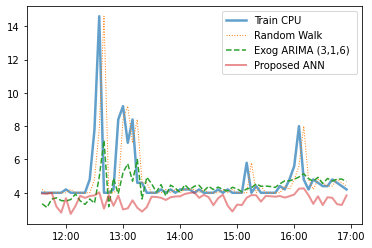

In [25]:
fig,ax = plt.subplots()
labs = ['12:00','13:00','14:00','15:00','16:00','17:00']

ax.set_xticklabels(labs)
#ax.set_ylim(0,15)
_ = ax.plot(pd.Series(Y_in_test,index = test_in_index),linewidth=2.5,label='Train CPU',alpha=0.7)
_ = ax.plot(pd.Series(rw_in_forecast,index = test_in_index),linewidth=1,linestyle='dotted',label = 'Random Walk')
_ = ax.plot(pd.Series(arima_in_forecast ,index = test_in_index),linewidth=1.5,linestyle='dashed',label = 'Exog ARIMA (3,1,6) ')
_ = ax.plot(pd.Series(ann_in_forecast ,index = test_in_index),linewidth=2,alpha=0.5, label = 'Proposed ANN')

plt.legend(loc='upper right')

plt.show()

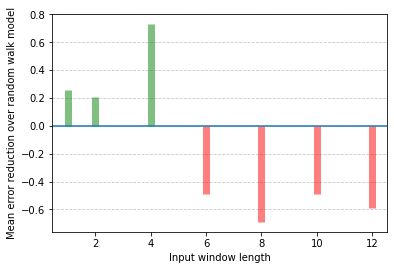

In [26]:
diff = pd.Series([0.26,0.21,0.73,-0.49,-0.69,-0.49,-0.59])
diff.index = [1,2,4,6,8,10,12]

diff = pd.DataFrame(diff,columns=['diff'])
diff['colors'] = ['red' if x < 0 else 'green' for x in diff['diff']]

diff.sort_values('diff', inplace=True)
diff.reset_index(inplace=True)

fig, ax = plt.subplots()
ax.set_xlabel('Input window length')
ax.set_ylabel('Mean error reduction over random walk model')
plt.vlines(x=diff['index'], ymin=0, ymax=diff['diff'], color=diff.colors, alpha=0.5, linewidth=7)
plt.grid(linestyle='--', alpha=0.7,axis='y')
plt.axhline()

plt.show()


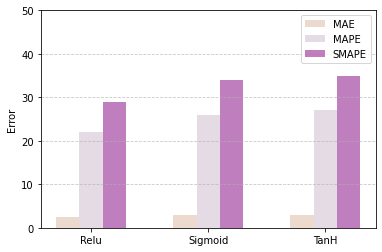

In [27]:
labels = ['Relu', 'Sigmoid', 'TanH']
ind = np.arange(3)
err_mape = [22,26,27]
err_smape = [29,34,35]
err_mae = [2.5,3,3]
width = 0.2

fig, ax = plt.subplots()
ax.set_ylabel('Error')
ax.set_ylim(0,50)
plt.bar(ind-width, err_mae , width, label='MAE',alpha=0.5,color='#DCB69F')
plt.bar(ind, err_mape , width, label='MAPE',alpha=0.5,color='#CAB8CB')
plt.bar(ind+width, err_smape , width, label='SMAPE',alpha=0.5,color='purple')
plt.xticks(ind, labels)
plt.grid(linestyle='--', alpha=0.7,axis='y')
plt.legend()
plt.show()
